<a href="https://colab.research.google.com/github/GwiHwan-Go/Reproduce_CutMix/blob/main/Training/CutMix_baseline_tinyImagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

--2022-05-18 17:21:18--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  5.75MB/s    in 57s     

2022-05-18 17:22:21 (4.12 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

test  train  val  wnids.txt  words.txt


In [1]:
import json
import os
import torch


In [5]:

training_data_list = []
for folder in os.listdir('./tiny-imagenet-200/train/'):
  label = folder  # The name of the folder is the label of the images it contains
  for file in os.listdir('./tiny-imagenet-200/train/' + folder + '/images/'):
    file_dir = './tiny-imagenet-200/train/' + folder + '/images/' + file
    training_data_list.append((file_dir, label))
with open('./training_data_list.json', 'w') as f:
  json.dump(training_data_list, f)

testing_data_list = []
with open('./tiny-imagenet-200/val/val_annotations.txt', 'r') as f:
  for line in f.readlines():
    file, label = line.split()[0:2]
    file_dir = './tiny-imagenet-200/val/images/' + file
    testing_data_list.append((file_dir, label))

with open('./testing_data_list.json', 'w') as f:
  json.dump(testing_data_list, f)

In [2]:
with open('./tiny-imagenet-200/wnids.txt', 'r') as f :
  label_id = f.readlines()
label_id = [i[:-1] for i in label_id]
len(label_id)

200

In [3]:

from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data.dataloader import *
import cv2 # OpenCV


In [8]:
class TinyImageDataset(Dataset):
  def __init__ (self, data, transform) :
    
    self.data = data
    self.transform = transform

  def __getitem__(self, index):
    img_path, label = self.data[index]
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
    if self.transform is not None:
      img = self.transform(img)
    return img, label_id.index(label)

  def __len__(self):
    return len(self.data)

In [19]:
import torch
import random

__all__ = ["Compose", "Lighting", "ColorJitter"]

class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class Grayscale(object):

    def __call__(self, img):
        gs = img.clone()
        gs[0].mul_(0.299).add_(0.587, gs[1]).add_(0.114, gs[2])
        gs[1].copy_(gs[0])
        gs[2].copy_(gs[0])
        return gs


class Saturation(object):

    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        gs = Grayscale()(img)
        alpha = random.uniform(-self.var, self.var)
        return img.lerp(gs, alpha)


class Brightness(object):

    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        gs = img.new().resize_as_(img).zero_()
        alpha = random.uniform(-self.var, self.var)
        return img.lerp(gs, alpha)


class Contrast(object):

    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        gs = Grayscale()(img)
        gs.fill_(gs.mean())
        alpha = random.uniform(-self.var, self.var)
        return img.lerp(gs, alpha)


class ColorJitter(object):

    def __init__(self, brightness=0.4, contrast=0.4, saturation=0.4):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation

    def __call__(self, img):
        self.transforms = []
        if self.brightness != 0:
            self.transforms.append(Brightness(self.brightness))
        if self.contrast != 0:
            self.transforms.append(Contrast(self.contrast))
        if self.saturation != 0:
            self.transforms.append(Saturation(self.saturation))

        random.shuffle(self.transforms)
        transform = transforms.Compose(self.transforms)
        # print(transform)
        return transform(img)

In [12]:

with open('./training_data_list.json', 'r') as f:
  train_data = json.load(f)
with open('./testing_data_list.json', 'r') as f:
  test_data = json.load(f)


In [22]:
batch_size = 256

jittering = ColorJitter(brightness=0.4, contrast=0.4,
                            saturation=0.4)
lighting = Lighting(alphastd=0.1,
                        eigval=[0.2175, 0.0188, 0.0045],
                        eigvec=[[-0.5675, 0.7192, 0.4009],
                                [-0.5808, -0.0045, -0.8140],
                                [-0.5836, -0.6948, 0.4203]])

train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            jittering,
            lighting,
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
            transforms.ToTensor(),

        ])
test_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),

            transforms.ToTensor(),

        ])

In [23]:
from sklearn.model_selection import train_test_split


train_dataset = TinyImageDataset(data = train_data, transform = train_transform)
test_dataset = TinyImageDataset(data = test_data, transform = test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

batch = next(iter(train_loader))
images, labels = batch


TypeError: Unexpected type <class 'numpy.ndarray'>

In [10]:
import matplotlib.pyplot as plt
import torchvision

plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

class labels: tensor([114,  20,  37, 123,  19, 139, 112, 139,  31, 180,  38, 123, 124,  65,
          8,  43, 130, 121, 196,  81, 141,  83,  91,  41, 181,  96,  12, 196,
         31,  87,  98, 188, 185,  63, 149, 101,  47,  74,  32, 129,  37, 185,
        197, 131,  24,  96,  22, 163,  44,   3,  84, 170, 195, 152, 174,  14,
         96, 153, 184, 169,  50,  91,  43,  83,  77, 185,  65,   6, 148, 173,
        182,  38,  30, 109,  40,  95, 123, 110, 128,  35,  89, 154,  89, 196,
        129, 195, 194, 180, 164,  77,  97,  33, 164, 105, 100,  43, 111,  25,
         94,  18,  95, 171, 101,  16, 168,  39, 135, 121,  86, 178,  43, 114,
         92, 190, 112,   7,  82,  72,  99,  26,  19,  68,  29,  64,  45, 137,
        182,  80, 145,  40,  55,  66,  83,  25, 154, 188,  29, 138, 116,  47,
         77, 177,  46, 151,  23,  72,  23, 114, 188, 168,  46, 152, 179, 128,
        172,  30,  48, 182, 110, 156, 146, 187, 189,  47, 144, 194, 157,  90,
        175,  15,  35, 189, 156,  21,  37, 101,   

In [10]:
import numpy as np

def cut(W,H,lam):
        
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [12]:
images, labels = next(iter(train_loader))
rand_index = torch.randperm(images.shape[0])
shuffled_images = images[rand_index]
lam = np.random.beta(1.0, 1.0)
cutmix_images = images.clone().detach()
cutout_images = images.clone().detach() 
mixup_images = images.clone().detach() 

bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix

In [13]:
## CUTMIX ##
cutmix_images[:, :, bbx1:bbx2, bby1:bby2] = cutmix_images[rand_index, :, bbx1:bbx2, bby1:bby2]
## CUTOUT ##
cutout_images[:, :, bbx1:bbx2, bby1:bby2] = 0.
## MIXUP ##
mixup_images = lam * mixup_images + (1 - lam) * mixup_images[rand_index,:,:]

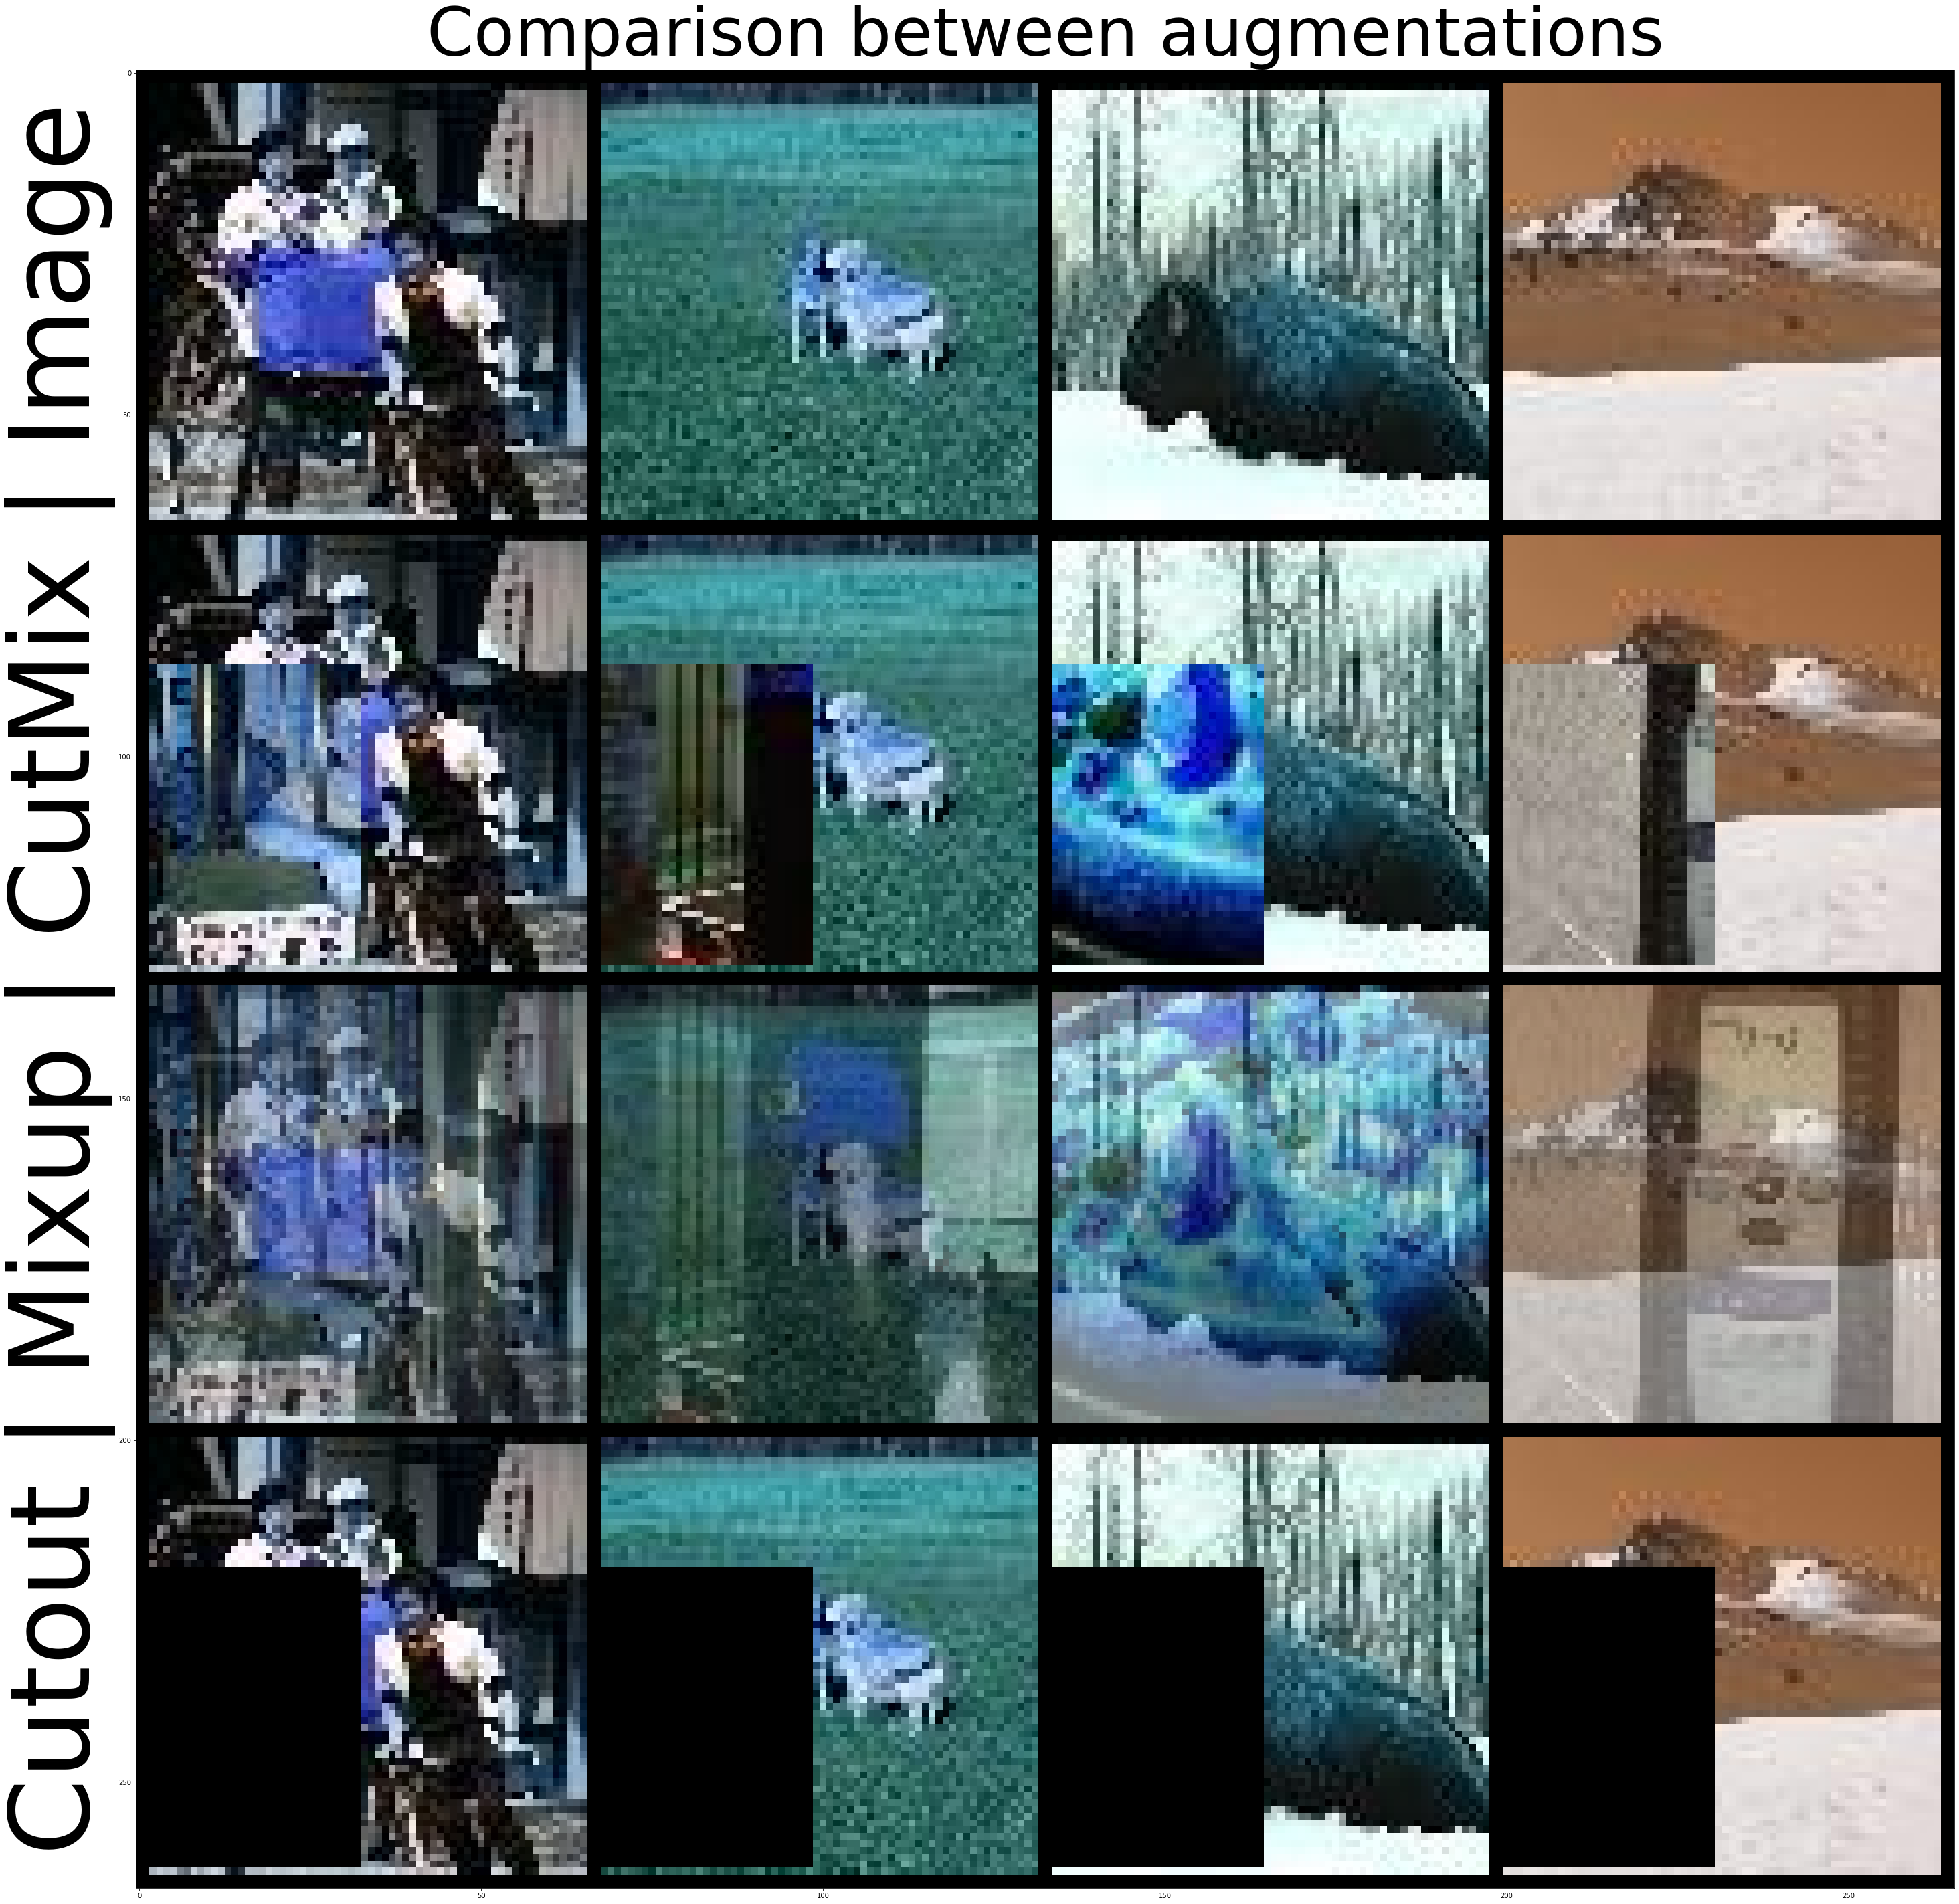

In [14]:
  
def show_cutMixed_compare(row1, row2, row3, row4, nums_show):
    rand_index = torch.randperm(row1.size()[0])[:nums_show]
    to_compare = torch.cat([row1[rand_index,:,:],row2[rand_index,:,:],row3[rand_index,:,:],row4[rand_index,:,:]],dim=0)
    plt.figure(figsize=(50,50))
    grid = torchvision.utils.make_grid(tensor=to_compare, nrow=nums_show)
    plt.ylabel("Cutout | Mixup | CutMix | Image",fontsize=165, rotation = 90)
    plt.title("Comparison between augmentations", fontsize=100)
    plt.imshow(grid.permute(1,2,0))

show_cutMixed_compare(images, cutmix_images, mixup_images, cutout_images, 4)

In [14]:
from torch.nn import Linear
from torchvision import models

# resnet50 Model Loading
use_pretrained = False
model = models.resnet50(pretrained=use_pretrained)
## 우리 이미지 사이즈에 맞게 튜닝

model.fc = torch.nn.Linear(2048, len(labels)) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# model = model.to(device)

cuda


In [15]:
import torch.optim as optim
import torch.nn as nn
from tqdm.auto import tqdm, trange

    
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))
    return res
    
def train_model(model, 
                train, 
                valid,
                resume = None,
                n_iters=300, 
                learn_rate=0.1, 
                weight_decay=0, 
                which_method=0
                ):  # Lists to store model's performance information
  po = 0
  top1_errs, top5_errs = [], []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

###############Checkpoint Zone################
  if resume is not None :
    checkpoint = torch.load(resume) 
    model.load_state_dict(checkpoint['model_state_dict'])
    loss = checkpoint['loss']
    num_epochs = checkpoint['total_epochs'] - checkpoint['epoch']
    top1_errs = checkpoint['top1_err']
    top5_errs = checkpoint['top5_err']
  else :
    num_epochs = n_iters
###############Checkpoint Zone###############
  
  print(f"We still have to go {num_epochs} epochs" )
  for i in trange(num_epochs):

    ##############################learning_decay#####################################
    if (num_epochs-i) < 75 :
      newpo = 3
    elif (num_epochs-i) < 150 :
      newpo = 2
    elif (num_epochs-i) < 225 :
      newpo = 1
    else :
      newpo = 0
    if po != newpo :
      po = newpo
      lr = learn_rate * (0.1 ** po) ##learning_decay
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    ##############################learning_decay#####################################

    try :
      for images, labels in tqdm(train) :

        images, labels = images.to(device), labels.to(device)
        model.train() # For Dropout and Batch Norm layers #

        if which_method and (np.random.rand()<0.5) :

          lam = np.random.beta(1.0, 1.0)
          rand_index = torch.randperm(images.size()[0])
          shuffled_labels = labels[rand_index]

          ##############Do Something On Data###############
          if which_method == 1 : ##cutmix
            bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.shape[-1] * images.shape[-2]))
          if which_method == 2 : ##mixup
            images = lam * images + (1 - lam) * images[rand_index,:,:]
          if which_method == 3 : ##cutout
            bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
            images[:, :, bbx1:bbx2, bby1:bby2] = 0.
          ##############Do Something On Data###############

          #############Forward Pass##############
          out = model(images) 
          #############Forward Pass##############

          ##############Modify Loss Function###############
          if which_method == 1 : ##cutmix
            loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam) # compute the total loss
          if which_method == 2 : ##mixup
            loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam)
          if which_method == 3 : ##cutout
            loss = criterion(out, labels)
          ##############Modify Loss Function###############

        else : ## if random.rand > 0.5 or which_method == 0
          
          out = model(images)
          loss = criterion(out, labels)

        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # reset the gradients for the next iteration
      
      #####################model Evaluation#############
      model.eval()
      sum_top1, sum_top5 = 0,0

      for images, labels in valid :
        images,labels = images.to(device), labels.to(device)
        output = model(images)
        top1, top5 = accuracy(output, labels, topk=(1,5))
        sum_top1+=top1.item()
        sum_top5+=top5.item()

      size = len(valid)
      #####################model Evaluation#############

      ###################save history#####################
      top1_errs.append(sum_top1/size)
      top5_errs.append(sum_top5/size)
      ###################save history#####################

      if (i+1) % 10 == 0 :

        PATH=f"./{300-(num_epochs-i)}th_checkpoint.pt"
        torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 
        'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'top1_err': top1_errs, 'top5_err': top5_errs }, PATH)
        print(f"Successfully saved untill {i} step in {PATH} with model, optimizer, and loss.")

    except :
      PATH=f"./{300-(num_epochs-i)}th_checkpoint.pt"
      torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 
      'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'top1_err': top1_errs, 'top5_err': top5_errs }, PATH)
      print(f"Successfully saved untill {i} step in {PATH} with model, optimizer, and loss.")
      return [top1_errs,top5_errs]

  PATH = "./trained.pt"
  print("train finished")
  print(f"Successfully saved untill {n_iters} step in {PATH} with model, optimizer, and loss.")
  torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 
  'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'top1_err': top1_errs, 'top5_err': top5_errs}, PATH)
  return [top1_errs,top5_errs]


In [16]:
##You should run this cell ONLY FIRST TIME!!!
##Otherwise It will OverWrite your Checkpoint file.

logs = train_model(model, train_loader, valid_loader, n_iters=300, 
                    learn_rate=0.1, 
                    weight_decay=0, which_method=1) 

#which method 
# 0: nothing, 
# 1: cutmix, 
# 2: mixup 
# 3: cutout

We still have to go 300 epochs


UnboundLocalError: local variable 'loss' referenced before assignment

In [54]:
## Chek point load 요령 ##
PATH="_" ## Where checkpoint saved. ## saved checkpoint

train_model(model,
            train_loader, 
            valid_loader,
            n_iters=300, 
            learn_rate=0.1, 
            resume=PATH,
            weight_decay=0, 
            which_method=1) 

Successfully saved untill 0 step in ./checkpoint.pt with model, optimizer, and loss.


[]

## Evaluate

In [ ]:
## If train was succeed, let's evaluate it.

In [1]:
PATH="./trained.pt"
checkpoint = torch.load(PATH) 
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
sum_top1, sum_top5 = 0,0

for images, labels in valid_loader :
    images,labels = images.to(device), labels.to(device)
    output = model(images)
    top1, top5 = accuracy(output, labels, topk=(1,5))
    sum_top1+=top1.item()
    sum_top5+=top5.item()

size = len(valid_loader)

print(sum_top1/size, sum_top5/size)

NameError: name 'torch' is not defined

In [55]:
checkpoint['top1_err']

[39.275, 38.73]

https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py